<a href="https://colab.research.google.com/github/aninda-ghosh/Deep-Learning/blob/master/Traffic_Signal_Analysis_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Let's Import the necessary libraries**

In [2]:
import matplotlib
matplotlib.use("Agg")
from PIL import Image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# import the necessary tensorflow packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


**Let's bring the datasets for analysis**

In [3]:
train_data = sio.loadmat("/content/drive/MyDrive/Machine Learning/Dataset/trainset.mat")
test_data = sio.loadmat("/content/drive/MyDrive/Machine Learning/Dataset/testset.mat")

image_width = 32
image_height = 32
classes = 43

**Defining ANN Model**

In [17]:
model = Sequential()
model.add(Dense(512,input_shape =(1024,),activation='relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(43,activation = 'sigmoid'))
model.compile(Adam(0.1), 'binary_crossentropy', 'accuracy')

**Images are to be resized and flattened**

In [ ]:
trainX = []
testX = []

#Applying image transform to resize everything into 32x32 pixels and applying CLAHE method to improve the contrast.
no_TrainImages = len(train_data['X'])
for i in range(0,no_TrainImages):
  # check to see if we should show a status update
  if i > 0 and i % 1000 == 0:
    print("[Train INFO] processed {} images / {} total images".format(i, no_TrainImages))
  train_data['X'][i] = transform.resize(train_data['X'][i], (32,32))
  image = np.dot(train_data['X'][i][...,:3],[0.299, 0.587,0.114])
  trainX.append(image.flatten())
 
#Applying image transform to resize everything into 32x32 pixels and applying CLAHE method to improve the contrast.
no_TestImages = len(test_data['X'])
for i in range(0,no_TestImages):
  # check to see if we should show a status update
  if i > 0 and i % 1000 == 0:
    print("[Test INFO] processed {} total images / {} total images".format(i, no_TestImages))
  test_data['X'][i] = transform.resize(test_data['X'][i], (32,32))
  image = np.dot(test_data['X'][i][...,:3],[0.299, 0.587,0.114])
  testX.append(image.flatten())

In [33]:

trainX = np.asarray(trainX)
testX = np.asarray(testX)

Since we have multiple labels, we have to do one hot encoding for performing the network training

In [34]:
# one-hot encode the training and testing labels
print(len(np.unique(train_data['Y'])))

numLabels = len(np.unique(train_data['Y']))
train_Y = to_categorical(train_data['Y'], numLabels)
test_Y = to_categorical(test_data['Y'], numLabels)

# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = train_Y.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

43


**We will use image data generator for augmenting various kinds of  image data like rotating the image or zooming in. This is for ensuring the network is not too biased**

In [35]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 10
INIT_LR = 1e-3
BS = 64


# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Training the network**

In [36]:
# train the network

print("[INFO] training network...")
H = model.fit(
		trainX,
		train_Y,
		validation_data=(testX, test_Y),steps_per_epoch=len(trainX) // BS,
		epochs=NUM_EPOCHS,
		class_weight=classWeight)

[INFO] training network...
Epoch 1/10
612/612 [==============================] - 8s 11ms/step - loss: 4.5487 - accuracy: 0.4822 - val_loss: 1.1095 - val_accuracy: 0.7413
Epoch 2/10
612/612 [==============================] - 7s 11ms/step - loss: 1.6835 - accuracy: 0.7955 - val_loss: 0.9085 - val_accuracy: 0.8137
Epoch 3/10
612/612 [==============================] - 8s 13ms/step - loss: 1.1590 - accuracy: 0.8568 - val_loss: 0.7744 - val_accuracy: 0.8396
Epoch 4/10
612/612 [==============================] - 7s 12ms/step - loss: 0.9078 - accuracy: 0.8854 - val_loss: 0.7570 - val_accuracy: 0.8514
Epoch 5/10
612/612 [==============================] - 7s 12ms/step - loss: 0.7055 - accuracy: 0.9096 - val_loss: 0.6690 - val_accuracy: 0.8713
Epoch 6/10
612/612 [==============================] - 8s 13ms/step - loss: 0.5633 - accuracy: 0.9274 - val_loss: 0.6546 - val_accuracy: 0.8775
Epoch 7/10
612/612 [==============================] - 9s 14ms/step - loss: 0.4879 - accuracy: 0.9341 - val_loss: 0.

612/612 [==============================] - 6s 11ms/step - loss: 0.3444 - accuracy: 0.9512 - val_loss: 0.6151 - val_accuracy: 0.8909


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 43)                22059     
                                                                 
Total params: 809,515
Trainable params: 809,515
Non-trainable params: 0
_________________________________________________________________


**We will run the prediction and generate the classification report.**

In [39]:
labelNames = np.unique(train_data['Y'])

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)

print(classification_report(test_Y.argmax(axis=1),predictions.argmax(axis=1)))

[INFO] evaluating network...
198/198 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.19      0.97      0.32        60
           1       0.63      0.70      0.66       720
           2       0.96      0.94      0.95       660
           3       0.92      0.95      0.93       420
           4       0.93      0.91      0.92       690
           5       0.88      0.99      0.94       720
           6       0.77      0.98      0.86       270
           7       0.94      0.96      0.95       210
           8       0.65      0.97      0.78       150
           9       0.95      0.88      0.91       360
          10       0.84      0.72      0.78       390
          11       0.54      0.87      0.66        60
          12       0.85      0.69      0.76       750
          13       0.64      0.92      0.75        90
          14       0.87      0.51      0.64        90
          15       0.83      0.84      0.83       1

**We plot the training accuracy and other parameters for visual confirmation.**

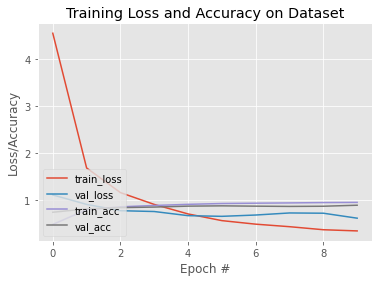

In [40]:
# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

**Lastly we save the model for future usage.**

In [ ]:
# save the network to disk
model.save('/content/drive/MyDrive/Machine Learning/Models')